In [1]:
import numpy as np
import matplotlib.pyplot as plt
import hyperspy.api as hs

import plotly.express as px
import plotly.graph_objects as go

from utils.helper_plotting import plotly_simple
from utils.get_raw_data import (
    sum_multiple_data_arrays,
    get_multiple_data_arrays,
)
from utils.gaussian_fitting import fit_peak_to_gaussian, fit_two_peaks_to_two_gaussians, fit_n_peaks_to_gaussian, gaussian

In [31]:
%load_ext autoreload
%autoreload 2 # or 1?????

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
arrays_Ga30 = get_multiple_data_arrays(filters=["GaAs_30kV"])
arrays_Mo30 = get_multiple_data_arrays(filters=["Mo_30kV"])

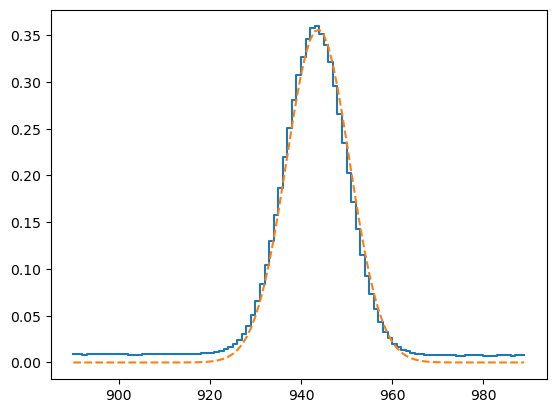

In [4]:
start = 890
stop = 990
x2048 = np.arange(0, 2048, 1) # evt ...arange(start, stop, 1)

xy_est = fit_peak_to_gaussian(arrays_Ga30, 945, start=start, stop=stop)

plt.step(x2048[start:stop], arrays_Ga30[0][1][start:stop])
plt.plot(xy_est[0], xy_est[1], "--")

cov = fit_peak_to_gaussian(arrays_Ga30, guess_peak=945, start=start, stop=stop, give_xy=False)


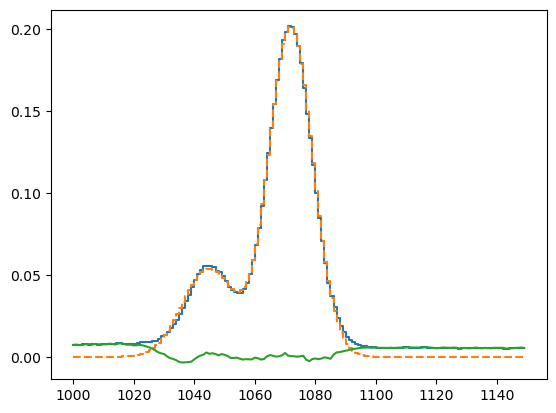

In [5]:
start = 1000
stop = 1150
x2048 = np.arange(0, 2048, 1) # evt ...arange(start, stop, 1)

xy_est = fit_two_peaks_to_two_gaussians(arrays_Ga30, [1045, 1075], start=start, stop=stop)

plt.step(x2048[start:stop], arrays_Ga30[0][1][start:stop])
plt.step(xy_est[0], xy_est[1], "--")
plt.plot(xy_est[0], arrays_Ga30[0][1][start:stop]- xy_est[1], "-")

xy_cov = fit_two_peaks_to_two_gaussians(arrays_Ga30, [1045, 1075], start=start, stop=stop, give_xy=False)


1036 1054


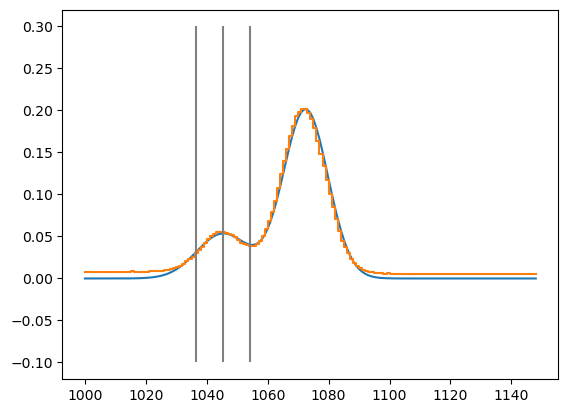

In [6]:
y_raw = arrays_Ga30[0][1]

plt.plot(x2048[start:stop-1], xy_est[1][:-1])
plt.step(x2048[start:stop-1], y_raw[start:stop-1])

width = round(np.sqrt(xy_cov[0][1]))
top = xy_cov[0][0]
plt.vlines(top, -.1, .3, color='gray')
plt.vlines(top - width*3, -.1, .3, color='gray')
plt.vlines(top + width*3, -.1, .3, color='gray')

left = round(top - width*3)
right = round(top + width*3)
print(left,right)


In [8]:
def plotly_fitting_plot(
    arrays, xy_est=None, vlines=None, bg_line=None, gauss_arr=None, start=0, stop=2048, show=True, mode="lines+markers"
):
    """
    Using plotly to make an interactive plot from the first element in arrays.

    Returns a plotly figure object.
    """
    y_raw = arrays[0][1]
    x2048 = np.arange(0, 2048, 1)  # making the 2048 long x-axis as channel numbers
    fig = go.Figure()
    fig.add_trace(
        go.Scatter(
            x=x2048[start:stop],
            y=y_raw[start:stop],
            mode=mode,
            name=f'raw {arrays[0][0]}',
        )
    )
    if xy_est:  # is false if None
        fig.add_trace(
            go.Scatter(
                x=xy_est[0],
                y=xy_est[1],
                mode='lines',
                name='gaussian fit',
            )
        )
    if vlines:
        for hline in vlines:
            fig.add_vline(x=hline, line_dash='dot', annotation_text=f'{hline:.1f}', line_width=0.3, annotation_font_size=8)
    if bg_line:
        fig.add_trace(
            go.Scatter(
                x=bg_line[0],
                y=bg_line[1],
                mode='lines',
                name='background'
            )
        )
    if gauss_arr:
        for i in range(0, len(gauss_arr), 3):
            gauss_y = gaussian(x2048[start:stop], gauss_arr[i], gauss_arr[i+1], gauss_arr[i+2])
            fig.add_trace(
                go.Scatter(
                    x=x2048[start:stop],
                    y=gauss_y,
                    mode='lines',
                    name=f'mu={gauss_arr[i]:.1f}, sigma={gauss_arr[i + 1]:.1f}, amp={gauss_arr[i + 2]:.1f}'
                )
            )
    fig.update_layout(
        title="Fitting plot",
        xaxis_title="Channel number [~10eV]",
        yaxis_title="Relative intensity [a.u.]",
        legend_title="Plotted",
    )
    if show:
        fig.show()
    # fig.write_html("../plots/name.html")
    return fig


In [9]:

def linear_background_fit_around_one_peak(arrays, peak_guess, plot=False):
    # idea1: 
    # fit a gaussian, take the width, move the width*3 to the left and right,
    # then find the average of the 10 points out from the width*3,
    # then say that the background is a linear function between the two points.

    first_fit = fit_peak_to_gaussian(arrays, peak_guess, give_xy=False)
    xy_first_fit = fit_peak_to_gaussian(arrays, peak_guess, give_xy=True)
    width = round(first_fit[0][1])
    peak = round(first_fit[0][0])
    width_times_4 = width*4
    avg_over_n_channels = 10
    left0 = peak - width_times_4 - avg_over_n_channels
    left1 = peak - width_times_4 
    right0 = peak + width_times_4
    right1 = peak + width_times_4 + avg_over_n_channels

    y_raw = arrays[0][1]

    # left_fit = np.polyfit(x2048[left0:left1], y_raw[left0:left1], 1)
    # right_fit = np.polyfit(x2048[right0:right1], y_raw[right0:right1], 1)

    left_bg_y = y_raw[left0:left1].mean()
    right_bg_y = y_raw[right0:right1].mean()
    bg_line = [[left1, right0], [left_bg_y, right_bg_y]]

    if plot:
        plotly_fitting_plot(arrays, xy_first_fit, [left0, left1, peak, right0, right1], bg_line=bg_line)

    return bg_line
linear_background_fit_around_one_peak(arrays_Ga30, 945, plot=True)
linear_background_fit_around_one_peak(arrays_Mo30, 1762, plot=True)



[[1718, 1806], [0.0014449572113445944, 0.0010730767507504818]]

In [10]:
def gaussian_fit_with_bg_removal(arrays, peak_guess, plot=False, use_avg=True):
    # smt
    # bg removal is only estimated at the guessed peak, but subtracted for the whole spectrum
    # bg = linear_background_fit_around_one_peak(arrays, peak_guess, plot=False)
    # xy_est = fit_peak_to_gaussian(arrays_with_bg_removed, peak_guess, give_xy=True)
    # if plot:
    #     plotly_fitting_plot(arrays_with_bg_removed, xy_est, bg_line=bg, start=peak_guess-100, stop=peak_guess+100)
    bg = linear_background_fit_around_one_peak(arrays, peak_guess, plot=False)
    
    if use_avg:
        bg_y_avg = np.array(bg[1]).mean()
        arrays_with_bg_removed = [[arrays[0][0], arrays[0][1] - bg_y_avg]]
    else:
        bg_x = np.arange(bg[0][0], bg[0][1], 1)
        bg_y = np.linspace(bg[1][0], bg[1][1], len(bg_x)) # one y for each channel
        y_raw = arrays[0][1]
        # y_raw from 0:left1, y_raw-bg_y from left1:right0 and y_raw from right0:2048
        bg_removed_y = np.concatenate([y_raw[0:bg[0][0]], y_raw[bg[0][0]:bg[0][1]]-bg_y, y_raw[bg[0][1]:]])
        arrays_with_bg_removed = [[arrays[0][0], bg_removed_y]]

    xy_est = fit_peak_to_gaussian(arrays_with_bg_removed, peak_guess, give_xy=True)
    if plot:
        plotly_fitting_plot(arrays_with_bg_removed, xy_est, bg_line=bg)


# gaussian_fit_with_bg_removal(arrays_Mo30, 1762, plot=True, use_avg=False)
gaussian_fit_with_bg_removal(arrays_Ga30, 945, plot=True, use_avg=False)


    

In [11]:
# Trying to fit the whole spectrum
# def fit_n_peaks_to_gaussian(raw_y, guesses_peaks, guess_std=1, guess_amp=1, give_xy=True):

# 
raw_y_Ga30 = arrays_Ga30[0][1]
# guesses_peaks_Ga30 = [22, 47, 117, 130, 149, 195, 944, 1045, 1072, 1191]
guesses_peaks_Ga30 = [22, 46, 117, 130, 149, 195, 944, 1045, 1072, 1191]
guesses_amp_Ga30 = [0.11, 0.01, 0.07, 1.00, 0.39, 0.01, 0.35, 0.05, 0.20, 0.03]
       

fitted_xy = fit_n_peaks_to_gaussian(raw_y_Ga30, guesses_peaks_Ga30, guesses_amp=guesses_amp_Ga30, give_xy=True)
fitted_cov = fit_n_peaks_to_gaussian(raw_y_Ga30, guesses_peaks_Ga30, give_xy=False)

fitted_peaks = list(fitted_cov[0][::3])  # every third element is a peak, 2. is std, 3. is amp

fig = plotly_fitting_plot(arrays_Ga30, fitted_xy, fitted_peaks, gauss_arr=list(fitted_cov[0]), start=0, stop=2048)

In [12]:
fit_peaks = list(fitted_cov[0][::3])
fit_std = list(fitted_cov[0][1::3])


remove_peaks_num = [6]  # actual peak number, not index


for p in remove_peaks_num:
    fit_peaks.pop(p-1)
    fit_std.pop(p-1)

In [17]:
sigma_window = 4.5  # how many sigma to include in the window on each side of the peak
peak_window_start = [int(p - s * sigma_window) for p, s in zip(fit_peaks, fit_std)]
peak_window_stop = [int(p + s * sigma_window) for p, s in zip(fit_peaks, fit_std)]
# for i in range(len(peak_window_start)):  # might be handy
#     print(peak_window_start[i], peak_window_stop[i])  # might be handy
x_to_exclude = [peak_window_start[0], peak_window_stop[0]]
print('for')
for i in range(1, len(peak_window_start)):
    # print(x_to_exclude)  # might be handy
    temp_end = x_to_exclude[-1]
    if peak_window_start[i] > x_to_exclude[-1]:  # if start is not after last stop
        x_to_exclude.extend([peak_window_start[i], peak_window_stop[i]])
    else:
        if peak_window_stop[i] > temp_end:
            x_to_exclude[-1] = peak_window_stop[i]
        continue


for


In [21]:
y_without_peaks = raw_y_Ga30.copy()
for i in range(0, len(x_to_exclude), 2):
    y_without_peaks[x_to_exclude[i]:x_to_exclude[i+1]] = np.nan

In [30]:
plotly_simple([x2048, x2048], [raw_y_Ga30, y_without_peaks], names=['raw', 'only bg'], mode='lines', title='GaAs_30kV raw vs background')